In [34]:
import pandas as pd
import numpy as np
import os
import keras


%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Model
from keras import layers
from keras import Input
from sklearn.metrics import confusion_matrix,roc_curve, auc,recall_score,precision_score,f1_score
from keras.utils.vis_utils import plot_model

# 参数设置

In [35]:
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False


# from tensorflow import losses
daily_back=20
wenben_back=10
total_day=2159 #根据查看数据表，得到数值
train_num=1650



wenben_sort=2
batch_size=8
epochs=20
LSTM_num=100
dense_num=20


mix_file='daily_data.xlsx'
first_columns='search_index'



test_num=total_day-train_num

# 数据转换类，返回多个字典？

In [36]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.wenben_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target']
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

# 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [37]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back)


# 读取原始数据

In [38]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'

# wenben_dir='/Users/ccmac/Documents/毕业论文数据/每日均值'
daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 历史数据标准化函数norm

In [39]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 文本数据标准化函数wenben_norm

In [40]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)
    # media_attention_mean_value = df['media_attention'].mean(axis=0)


    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()
    # media_attention_std_value = df['media_attention'].std()


    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    # x['media_attention'] = (df['media_attention'] - media_attention_mean_value) / media_attention_std_value

    df=x
    return df

# 数据切分

In [41]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

# 进行数据切分

In [42]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1650, 8)
日频测试切分： (509, 8)
十五分钟频训练切分： (26400, 6)
十五分钟频测试切分： (8320, 6)
训练目标切分： (1650, 2)
测试目标切分： (520, 2)


# 调用类中的方法,处理原始数据

In [43]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)

wenben_train=DM.wenben_train_data(wenben_norm_train_df)

wenben_test=DM.wenben_test_data(wenben_norm_test_df)


(1630, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649],
      dtype='int64', length=1650)
日频训练array： (1630, 20, 5)
509 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_70365/3624395069.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == j, 'target']
/var/folders/5p/hvm0cq8x33b_42v5fj9lmxbh0000gn/T/ipykernel_70365/3624395069.py:116: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  targets[j] = data.loc[data.index == self.train_num+j, 'target'] ##出问题：应该是。而不是***：data.index == self.train_num+j


训练标签array (1630,)
(489,)
文本长期训练array： (1630, 10, 2)
长期文本测试array： (489, 10, 2)


# 构建神经网络模型

In [44]:
def my_model(wenben_back,wenben_sort):

    ##### 一、模型搭建

    # 文本输入训练(!!!卷积滤镜行列先后)
    wenben_input=Input(shape=(wenben_back,wenben_sort),dtype='float32',name='wenben_input')
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(wenben_input)
    LSTM_wenben=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 15分钟频输入训练(!!!卷积滤镜行列先后)
    fif_min_input=Input(shape=(16,5),dtype='float32',name='fif_min_input')
    # fif_min_input=(8,16,4,1)
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(fif_min_input)
    LSTM_fif=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 日频输入训练
    daily_input=Input(shape=(20,5),dtype='float32',name='daily_input')
    # daily_input=(8,16,4,1)
    Conv1D_daily=layers.Conv1D(16,1,strides=1)(daily_input)
    LSTM_daily=layers.LSTM(LSTM_num)(Conv1D_daily)
    # 15分钟频训练结果和日频训练结果合并
    concatenated=layers.concatenate([LSTM_fif,LSTM_daily,LSTM_wenben],axis=-1) # axis=-1按照最后一个轴粘合

    alloy=layers.Dense(dense_num,activation='relu')(concatenated) #将粘合结果再接一个全连接层
    dropout=layers.Dropout(0.2)(alloy)
    output=layers.Dense(1,activation='sigmoid')(dropout)
    model=Model([fif_min_input,daily_input,wenben_input],output) #八股文：将输入和输出圈起来

    print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])
    return model
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')


# 模型滞后时长赋值

In [45]:
model=my_model(wenben_back=wenben_back,wenben_sort=wenben_sort)


2025-03-04 17:59:36.223962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 17:59:36.224802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 17:59:36.225614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fif_min_input (InputLayer)     [(None, 16, 5)]      0           []                               
                                                                                                  
 daily_input (InputLayer)       [(None, 20, 5)]      0           []                               
                                                                                                  
 wenben_input (InputLayer)      [(None, 10, 2)]      0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 16, 16)       96          ['fif_min_input[0][0]']          
                                                                                            

2025-03-04 17:59:36.482939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 17:59:36.483753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 17:59:36.484523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# 添加输出模型参数的代码块

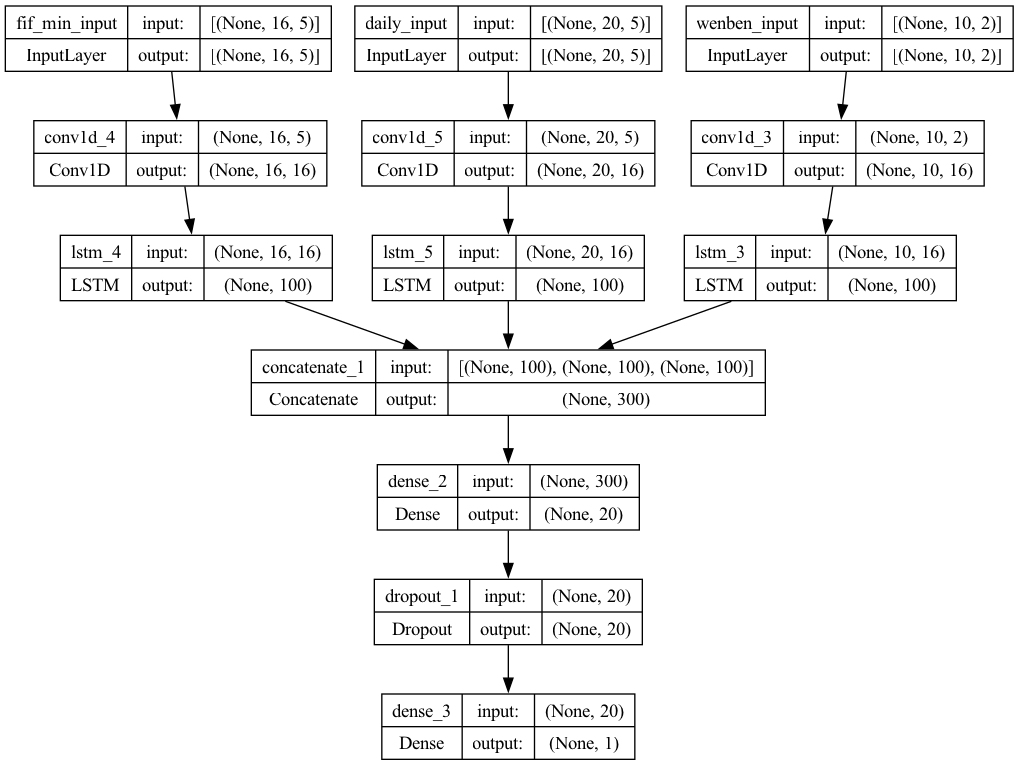

In [46]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# model.fit(输入自变量x，因变量y)

In [47]:
history=model.fit(x=[fif_train,daily_train,wenben_train],y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/20


2025-03-04 17:59:36.953764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 17:59:36.955364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 17:59:36.957212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

148/153 [============================>.] - ETA: 0s - loss: 0.6987 - acc: 0.5118

2025-03-04 17:59:40.870248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 17:59:40.871047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 17:59:40.871848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 5s 12ms/step - loss: 0.6993 - acc: 0.5155 - val_loss: 0.7378 - val_acc: 0.5049
Epoch 2/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6887 - acc: 0.5581 - val_loss: 0.7227 - val_acc: 0.5123
Epoch 3/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6884 - acc: 0.5417 - val_loss: 0.7091 - val_acc: 0.5147
Epoch 4/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6871 - acc: 0.5573 - val_loss: 0.7200 - val_acc: 0.5098
Epoch 5/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6855 - acc: 0.5417 - val_loss: 0.7215 - val_acc: 0.5270
Epoch 6/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6859 - acc: 0.5483 - val_loss: 0.7525 - val_acc: 0.5147
Epoch 7/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6862 - acc: 0.5475 - val_loss: 0.7145 - val_acc: 0.5196
Epoch 8/20
153/153 [==============================] - 1s 8ms/step - loss: 0.6850 - acc

# model.evaluate(输入测试数据)，进行模型预测性能测试

In [48]:
loss,accuracy = model.evaluate([fif_test,daily_test,wenben_test],y=target_test)
print(loss,accuracy)

2025-03-04 18:00:05.312384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 18:00:05.313375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 18:00:05.314117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 4ms/step - loss: 0.7314 - acc: 0.5542
0.7314018607139587 0.5541922450065613


# 构建y的函数

In [49]:
def gen_y_pred():
    y_predict=model.predict([fif_test,daily_test,wenben_test],batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [50]:
y_pred=gen_y_pred()
print(y_pred)

2025-03-04 18:00:06.064580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 18:00:06.065431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 18:00:06.066223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

489/489 [==============================] - 1s 1ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

#  构建使用测试集作为回测数据的类

In [51]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back,wenben_back):
        self.train_num=train_num
        self.daily_back=daily_back
        self.wenben_back = wenben_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.wenben_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [52]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20,wenben_back=daily_back)

# 

In [53]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [54]:
back_df=split_back_trader()['daily_test_df']

In [55]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1650,2022-11-03,2981.20,3003.72,2977.72,2997.81,259348567,261656,-0.804520
1651,2022-11-04,2997.00,3081.59,2997.00,3070.80,329806740,250605,-0.663122
1652,2022-11-07,3062.86,3088.19,3054.46,3077.82,320567097,255756,-0.706624
1653,2022-11-08,3077.31,3078.28,3047.46,3064.49,256522007,235956,-0.746056
1654,2022-11-09,3064.46,3073.92,3046.19,3048.17,235637324,229434,-0.947768
...,...,...,...,...,...,...,...,...
2154,2024-12-02,3328.48,3369.30,3323.01,3363.98,668477762,428407,-0.647137
2155,2024-12-03,3366.29,3386.62,3348.37,3378.81,663030139,438283,-0.861024
2156,2024-12-04,3376.57,3388.02,3352.94,3364.65,621028862,425902,-0.984183
2157,2024-12-05,3353.06,3377.06,3353.06,3368.86,543885746,397751,-0.812990


In [56]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659,
       ...
       2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158],
      dtype='int64', length=509)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [57]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+20+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+20+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

488
         open    close  rate_of_return  day_rate_of_return
1671  3160.58  3156.14       -0.002947           -0.001405
1672  3181.92  3211.81        0.017639            0.009394
1673  3200.28  3212.53        0.000224            0.003828
1674  3204.94  3199.62       -0.004019           -0.001660
1675  3196.02  3197.35       -0.000709            0.000416
...       ...      ...             ...                 ...
2154  3328.48  3363.98        0.011279            0.010666
2155  3366.29  3378.81        0.004408            0.003719
2156  3376.57  3364.65       -0.004191           -0.003530
2157  3353.06  3368.86        0.001251            0.004712
2158  3370.94  3404.08        0.010455            0.009831

[488 rows x 4 columns]
         open    close  rate_of_return  day_rate_of_return  last_close  \
1670  3187.99  3165.47             NaN           -0.007064         NaN   
1671  3160.58  3156.14       -0.002947           -0.001405     3165.47   
1672  3181.92  3211.81        0.017639    

# 回测交易逻辑

In [58]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+20 + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+20 + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+20 + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [59]:
result=backtrader(y_pred,backtrader_df)
print(result[1])
print(result[2])
print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


[-0.007064012120489682, -0.0029474296076096307, 0.017638634534589803, 0.0002241726627665308, -0.004018639514650535, -0.0007094592482856932, 0.0030024864340782997, -0.008702973230016009, -0.0008524586038552995, 6.296574978059688e-05, -0.002480694342568812, -0.000249317532703186, -0.01917382712619886, -0.0026294446303972707, 0.0023133827381500716, 0.0064644912619382655, 0.009789402262555758, -0.002639255452146161, -0.004437390684718601, 0.005062302762143478, -0.0005664787036377961, 0.0019085377393288638, 0.010148806474746364, 0.000766982967907115, 0.00583980441088916, -0.0020685876930051084, -0.002419932418575743, 0.0005091971763275804, 0.002181162970807282, 0.009088578467541186, -0.0010379261306424636, 0.0010390045406050152, 0.005423133776792266, 0.013495425461206079, -0.0018561386240879552, -0.006774873922213764, -0.00757183436957054, 0.0028993114521258523, -0.00491981441400946, 0.011840562357098072, -0.0029690739302467017, -0.0011286024038005271, 0.004523594693206734, -0.0046483916625

In [60]:
returns=result[3]
returns = [ret - 1 for ret in returns]
returns

[-0.007064012120489682,
 -0.009990621049626891,
 0.007471792571494884,
 0.007697640205897915,
 0.0036480666501463865,
 0.002936019247237409,
 0.005947321039275755,
 -0.0028074115665354116,
 -0.003657476968246254,
 -0.0035947415142452144,
 -0.006066518401876664,
 -0.0063143234451797925,
 -0.025367080825221877,
 -0.027929824121154412,
 -0.025681053756005823,
 -0.0193825774416706,
 -0.009782919026576464,
 -0.012396354856343827,
 -0.016778738071498434,
 -0.011801374361439576,
 -0.012361167837827924,
 -0.01047622185381969,
 -0.00043373652725420264,
 0.0003329137721239661,
 0.006174662334327952,
 0.00409330181080958,
 0.0016634638784829292,
 0.002173508085920428,
 0.00435941183208155,
 0.013487611156130841,
 0.012435685881429404,
 0.013487611156130841,
 0.018983890052552077,
 0.03273551118692608,
 0.030818610916144795,
 0.0238349447905164,
 0.016082636166784292,
 0.019028576190128765,
 0.014015144712701044,
 0.02602165426471359,
 0.022975320119167586,
 0.02182078771385254,
 0.026443090806563

In [61]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -145.87%


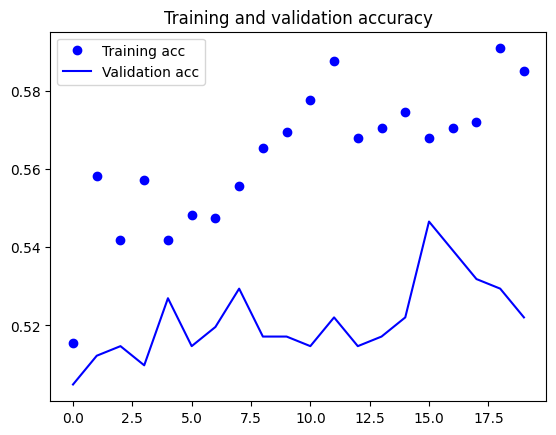

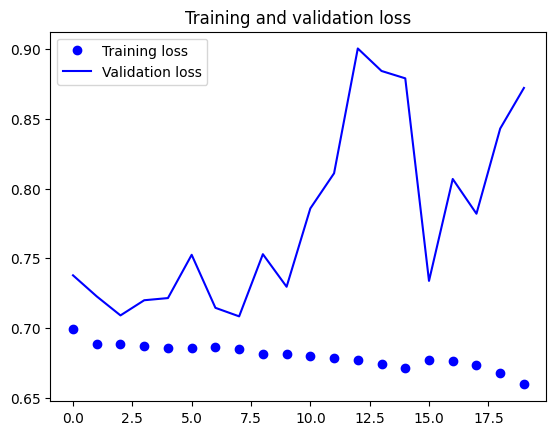

In [62]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [63]:
confusion_matrix = confusion_matrix(target_test, y_pred,labels=[1,0])
precision_score=precision_score(target_test, y_pred)
recall_score=recall_score(target_test, y_pred)
f1_score=f1_score(target_test, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[177  61]
 [157  94]]
查准率： 0.5299401197604791
查全率： 0.7436974789915967
f1-score: 0.6188811188811189


2025-03-04 18:00:07.729668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-04 18:00:07.730449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-04 18:00:07.731368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 1s 4ms/step


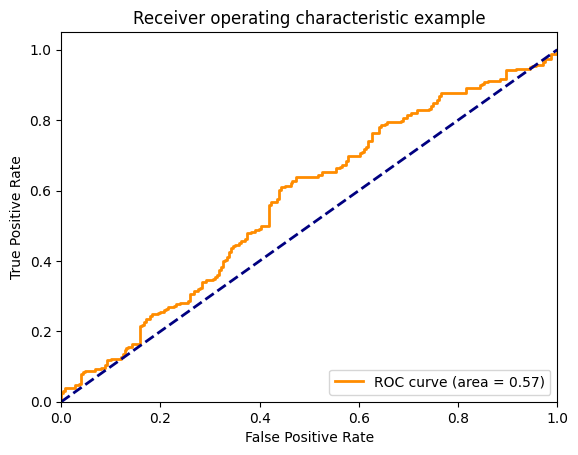

In [64]:
y_predict=model.predict([fif_test,daily_test,wenben_test]).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [65]:
df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
df10=pd.DataFrame({'每日收益率':result[1]})
path9='/Users/ccmac/Desktop'
df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [66]:
import numpy as np
t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
y = np.cumprod(t, axis=1)
print(t)
print(y)


[[1 2 3 4]
 [5 6 7 8]]
[[   1    2    6   24]
 [   5   30  210 1680]]
